In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib, vc_protocols
import mod_trace
from ord2011 import ORD2011

In [2]:
'''
O'Hara-Rudy CiPA v1.0 (2017)
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
current_li = ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1']

protocol = vc_protocols.hERG_CiPA()
# protocol = pickle.load(open("./trial_steps_ramps_Kernik_200_50_4_-120_60_paper/shortened_trial_steps_ramps_Kernik_200_50_4_-120_60_500_artefact_True_short.pkl", 'rb'))
# protocol = pickle.load(open("./trial_steps_ramps_ORD2011_288_51_4_-121_61/shortened_trial_steps_ramps_ORD2011_288_51_4_-121_61_500_artefact_False_short.pkl", 'rb'))

end_time = protocol.get_voltage_change_endpoints()[-1]
t_span = (0, end_time)
t_eval = np.linspace(0, end_time, 10000)
print(end_time)

3900


In [3]:
import simulator_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ohara-cipa-v1-2017_VC.mmt" 
model_myokit, protocol_myokit, script = myokit.load(model_path)
sim_myokit = simulator_myokit.Simulator(model_myokit, protocol, max_step=1.0, abs_tol=1e-8, rel_tol=1e-8, vhold=-8.80019046500000002e1) # 1e-12, 1e-14 # 1e-08, 1e-10  # max_step=1, atol=1E-2, rtol=1E-4 # defalt: abs_tol=1e-06, rel_tol=0.0001
sim_myokit.name = "OHara2017-CiPA-v1"

In [4]:
start_time = time.time()

sim_myokit.simulation.set_constant('cell.mode', cells['Epicardial'])    
y0_myokit = sim_myokit.pre_simulate(5000, sim_type=1)
d_myokit = sim_myokit.simulate(end_time, log_times=None, extra_log=current_li)

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.31205058097839355 seconds ---


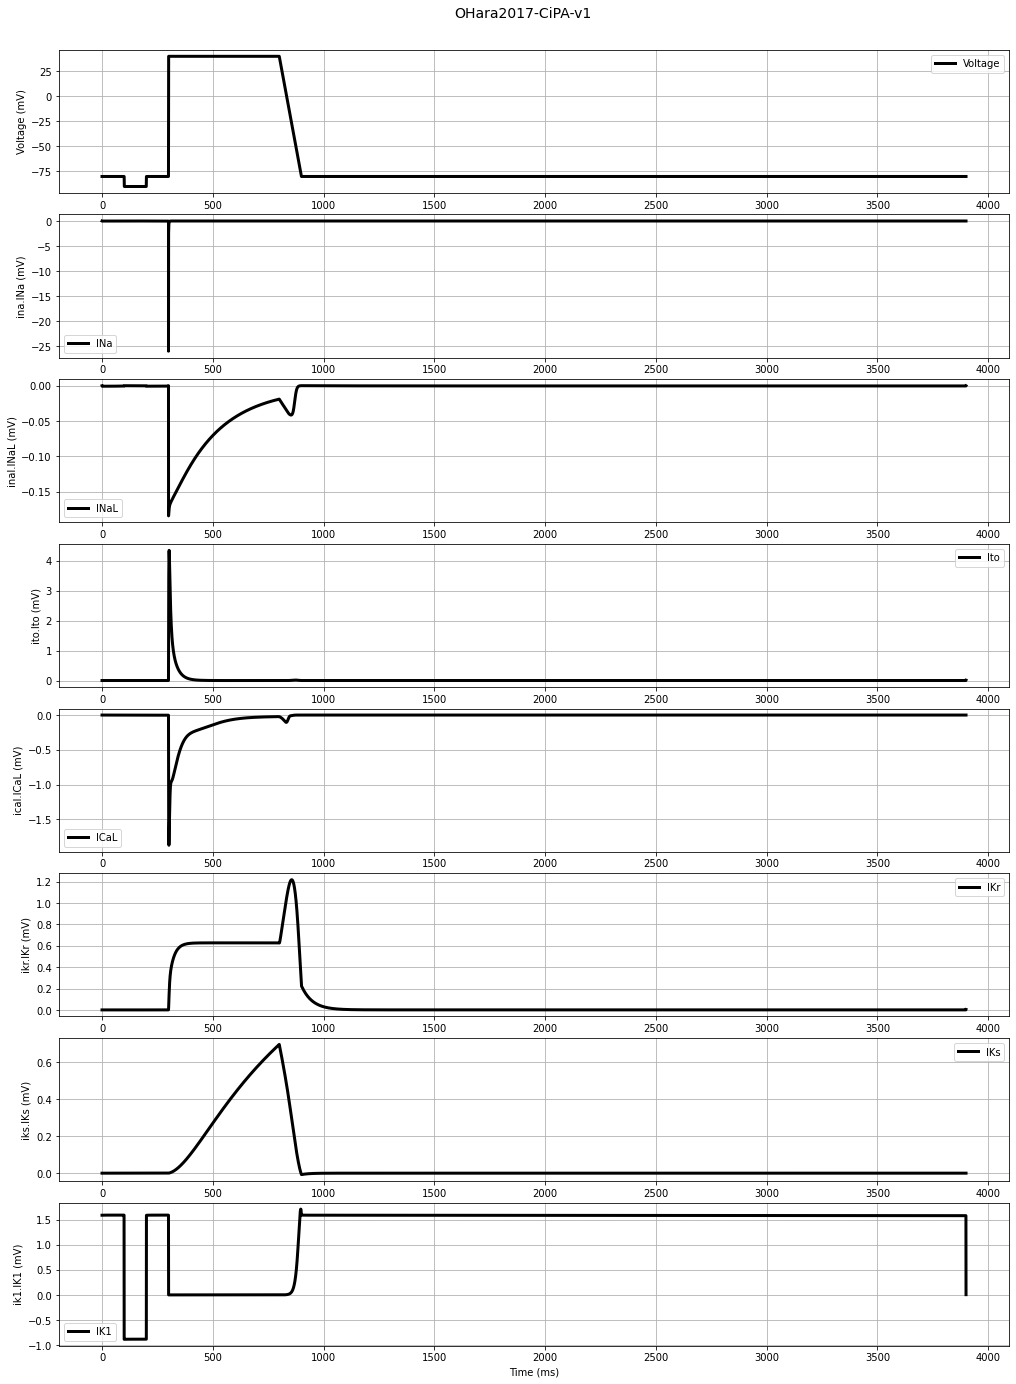

In [35]:
'''
Plot
'''
fig, axes = plt.subplots(8,1, figsize=(15,20))    
fig.suptitle(sim_myokit.name, fontsize=14)
plot_li = ['Voltage'] + current_li
for i, name in enumerate(plot_li):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[i].set_xlabel('Time (ms)')       
    axes[i].set_ylabel(f'{name} (mV)')  
    
    if i==0:                
        # axes[i].plot( d_myokit['engine.time'], protocol_myokit.value_at_times(d_myokit['engine.time']), label=name, color='k')           
        axes[i].plot( t_eval, [protocol.get_voltage_at_time(t) for t in t_eval], label=name, color='k', linewidth=3)                   
    else:
        name = name.split('.')[1]
        axes[i].plot( d_myokit['engine.time'], sim_myokit.current_response_info.get_current([name]), label=name, color='k', linewidth=3) 
        
    axes[i].legend()
    axes[i].grid()

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join('Results', "OHara2017-CiPA-v1-VC.jpg"), dpi=100)

In [6]:
print("Complete")

Complete
